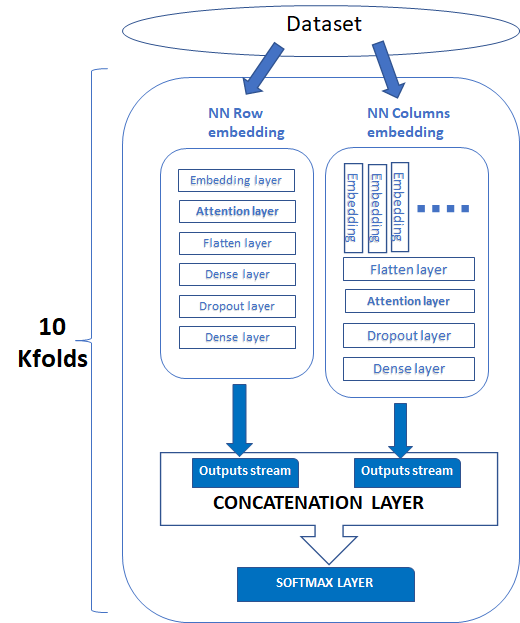

<h3> Adapted from Alexander Ryzhkov python translation of Oscar Villarreal Escamilla Notebook

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss

import gc

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers

from keras.models import Model


In [ ]:
train = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv')
test = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-jun-2021/sample_submission.csv")
submission = submission.set_index('id')


In [ ]:
targets = pd.get_dummies(train['target'])

In [ ]:
def custom_metric(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-15, 1-1e-15)
    loss = K.mean(cce(y_true, y_pred))
    return loss

cce = tf.keras.losses.CategoricalCrossentropy()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_metric', min_delta=1e-05, patience=5, verbose=1,
    mode='min', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_custom_metric', factor=0.7, patience=2, verbose=1,
    mode='min')

In [ ]:
def attention_model():
    attention_inputs = layers.Input(shape = (75,))
    embed = layers.Embedding(360, 8)(attention_inputs)
    embed = layers.Flatten()(embed)
    hidden = layers.Dropout(0.3)(embed)
    hidden = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='selu', kernel_initializer="lecun_normal"))(hidden)
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='relu'))(output) 
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden, output]))
        
    attention_outputs = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='elu'))(output) 
    
    return attention_inputs,attention_outputs

In [ ]:
def model_NN_by_column():
    model_NN_by_column_inputs = layers.Input(shape = (75,))
    b = layers.Reshape((-1,1))( model_NN_by_column_inputs)
    b = layers.Embedding(360, 8,input_length = 75)(b)
    embed = layers.Flatten()(b)
    hidden = layers.Dropout(0.3)(embed)
    hidden = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='selu', kernel_initializer="lecun_normal"))(hidden)
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='relu'))(output) 
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden, output]))
    
    model_NN_by_column_outputs = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='elu'))(output) 
    
    return model_NN_by_column_inputs,model_NN_by_column_outputs

In [ ]:
oof = np.zeros((train.shape[0],9))
pred = np.zeros((test.shape[0],9))

N_FOLDS = 10
SEED = 2021
EPOCH = 50

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, ts_idx) in enumerate(skf.split(train,train.iloc[:,-1])):
    print(f"\n ====== TRAINING FOLD {fold} =======\n")

    X_train = train.iloc[:,1:-1].iloc[tr_idx]
    y_train = targets.iloc[tr_idx]
    X_test = train.iloc[:,1:-1].iloc[ts_idx]
    y_test = targets.iloc[ts_idx]

    K.clear_session()
    
    #---------- Base API collection ---------------------
    
    attention_inputs, attention_ouputs = attention_model()
    model_NN_by_column_inputs,model_NN_by_column_outputs = model_NN_by_column()

    #---------- Concatenation Layer --------------------  
        
    z = layers.Concatenate(axis=1)(
                    [attention_ouputs,
                    model_NN_by_column_outputs,
                    ])
    out = layers.Dense(9, activation = 'softmax', name = 'out')(z)
    
     #----------Model creation---------------------
    
    model_merged = Model(
                    inputs=[
                    attention_inputs,
                    model_NN_by_column_inputs,
                    ], 
                    outputs=out, 
                    name="model_merged")
     #----------Model compile---------------------- 
    
    model_merged.compile(
                    tf.keras.optimizers.Adam(learning_rate=2e-4),
                    loss='categorical_crossentropy',  
                    metrics=custom_metric)

    #----------Model fit--------------------------- 
    
    model_merged.fit([X_train,
                    X_train],
                    y_train,
                    validation_data = ([
                    X_test,
                    X_test,
                    ],y_test),
                    batch_size = 256,
                    epochs = EPOCH,
                    verbose = 1,
                    callbacks = [es,plateau])
    
    #----------Model prediction----------------------
    
    oof[ts_idx] = model_merged.predict([X_test,
                                        X_test])
    score = log_loss(y_test, oof[ts_idx])
    print(f"\nFOLD {fold} Score {score}\n")
    pred += model_merged.predict([test.iloc[:,1:],
                                  test.iloc[:,1:]]) / N_FOLDS

score = log_loss(targets, oof)
print(f"Score total {score}\n")   

In [ ]:
submission = pd.read_csv("../input/tabular-playground-series-jun-2021/sample_submission.csv")
pred_embedding = pred
submission['Class_1']=pred_embedding[:,0]
submission['Class_2']=pred_embedding[:,1]
submission['Class_3']=pred_embedding[:,2]
submission['Class_4']=pred_embedding[:,3]
submission['Class_5']=pred_embedding[:,4]
submission['Class_6']=pred_embedding[:,5]
submission['Class_7']=pred_embedding[:,6]
submission['Class_8']=pred_embedding[:,7]
submission['Class_9']=pred_embedding[:,8]
submission.to_csv("concatenated4.csv", index=False)